# DFT's de alguns sinais e efeitos de escala.

Neste notebook vamos avaliar as DFT's de alguns sinais e efeitos de escala para a correção da magnitude. 

Nós podemos lembrar que a definição da DFT é admensional

\begin{equation}
X(k)=\sum \limits_{n=0}^{N-1}x[n] \mathrm{e}^{-\mathrm{j}\left(\frac{2 \pi}{N}\right)k \ n}.
\tag{1}
\end{equation}

Neste caso, para que a magnitude de $X(k)$ represente bem um dado sinal, ela deve ser corrigida de alguma forma. A fase não necessita dessa correção, pois é uma medida relativa entre as partes imaginária e real da DFT

\begin{equation}
\angle X(k)= \mathrm{arctan} \left( \frac{\Im m \left\{X(k)\right\}}{\Re e \left\{X(k)\right\}} \right).
\tag{2}
\end{equation}

Precisamos diferenciar entre sinais transientes e periódicos.

In [1]:
# importar as bibliotecas necessárias
import numpy as np # arrays
import matplotlib.pyplot as plt # plots
plt.rcParams.update({'font.size': 14})
import IPython.display as ipd # to play signals
from scipy import signal
import sounddevice as sd
import soundfile as sf

## 1. Sinais transientes

Sinais transientes tem ***energia finita*** e, neste caso, o único fator de escala aplicado é o intervalo de amostragem (ou frequência de amostragem - $F_s$). Vamos reavaliar o exemplo da aula passada.

resposta ao impulso de um sistema massa-mola (1DOF)

\begin{equation}
h(t) = \frac{A}{\omega_d} \mathrm{e}^{-\zeta \omega_n t} \mathrm{sin}(\omega_d t)
\end{equation}
com $\zeta$ sendo o amortecimento, $\omega_n = 2 \pi f_1$ e $\omega_d = \omega_n\sqrt{1-\zeta^2}$

In [11]:
# Define the sampling rate fs = 100 Hz and total record time T = 5 seconds
Fs=100
T=5 
# time vector
time = np.arange(0, T, 1/Fs)

# Sinal puro (Fenômeno) - original - h(t) de um S1GL (massa-mola)
A=200
zeta=0.3
wn=2*np.pi*10
wd=np.sqrt(1-zeta**2)*wn
# Impulse response
ht=(A/wd)*np.exp(-zeta*wn*time)*np.sin(wd*time)
# FRF teorica
freq = np.arange(0, Fs, 0.1)
Hw=A/(wn**2 - (2*np.pi*freq)**2+ 1j*2*zeta*wn*(2*np.pi*freq));

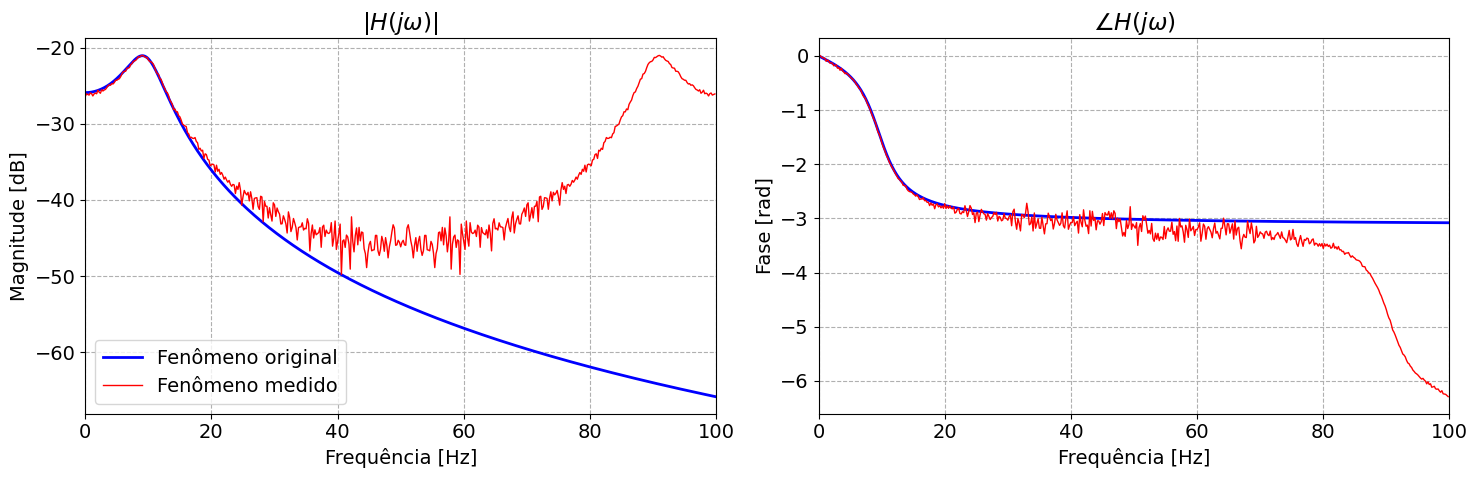

In [12]:
noise = np.random.normal(loc = 0, scale = 0.005, size = len(time))
ht_med = ht+noise

N = len(ht) # Número de pontos da FFT
Hw_med = np.fft.fft(ht_med)
freq_vec = np.linspace(0, (N-1)*Fs/N, N)


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title(r'$|H(j\omega)|$')
plt.plot(freq, 20*np.log10(np.abs(Hw)), '-b', linewidth = 2, label = 'Fenômeno original')
plt.plot(freq_vec, 20*np.log10(np.abs(Hw_med)/Fs), '-r', linewidth = 1, label = 'Fenômeno medido')
plt.legend(loc = 'lower left')
plt.grid(linestyle = '--', which='both')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [dB]')
plt.xlim((0, Fs))
#plt.ylim((-80, -20))

plt.subplot(1,2,2)
plt.title(r'$\angle H(j\omega)$')
plt.plot(freq, np.unwrap(np.angle(Hw)), '-b', linewidth = 2)
plt.plot(freq_vec, np.unwrap(np.angle(Hw_med)), '-r', linewidth = 1)
plt.grid(linestyle = '--', which='both')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Fase [rad]')
plt.xlim((0, Fs))
#plt.ylim((-4, 2))
plt.tight_layout()
plt.show()

## 2. Sinais "periódicos"

Sinais periódicos tem ***energia infinita*** e, neste caso, o sinal a magnitude da DFT é influenciada pela quantidade de amostras colhidas. Se lembrarmos da relação entre os coeficientes $\tilde{c}_k$ de Fourier e da DFT (de aulas anteriores) ou se usarmos o teorema de Parseval, fica claro que:

\begin{equation}
\tilde{c}_k = \frac{X(k)}{N}
\tag{3}
\end{equation}
em que $N$ é o número de amostras medidas.

Vamos investigar então um sinal cossenoidal com 2 frequências fundamentais, dado por:

\begin{equation}
x(t) = A_1 \mathrm{cos}(2 \pi f_1 t + \phi_1) + A_2 \mathrm{cos}(2 \pi f_2 t + \phi_2)
\end{equation}

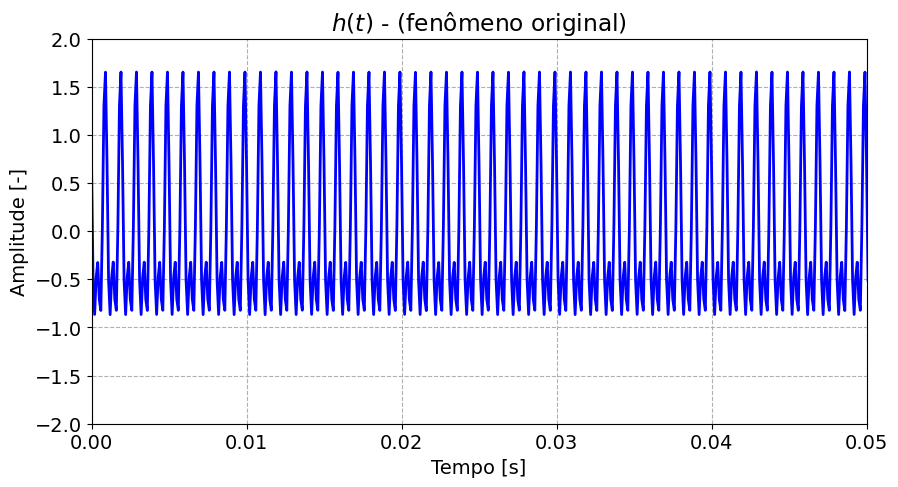

In [7]:
# Parâmetros do sinal
A1 = 1
f1 = 1000
phi1 = np.pi/4

A2 = 0.7
f2 = 2000
phi2 = np.pi/2

# Parâmetros temporais
Fs = 10000
t_max = 1
tx = np.arange(0, t_max+1/Fs, 1/Fs)

# sinal
xt = A1*np.cos(2*np.pi*f1*tx+phi1) + A2*np.cos(2*np.pi*f2*tx+phi2)
noise = np.random.normal(loc = 0, scale = np.std(xt)*10**(-30/10), size = len(xt))
xt += noise

# Time dommain
plt.figure(figsize = (10,5))
plt.title(r'$h(t)$ - (fenômeno original)')
plt.plot(tx, xt, '-b', linewidth = 2)
plt.grid(linestyle = '--', which='both')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude [-]')
plt.xlim((0, 0.05))
plt.ylim((-2, 2))

ipd.Audio(xt, rate=Fs) # load a NumPy array

### DFT do sinal

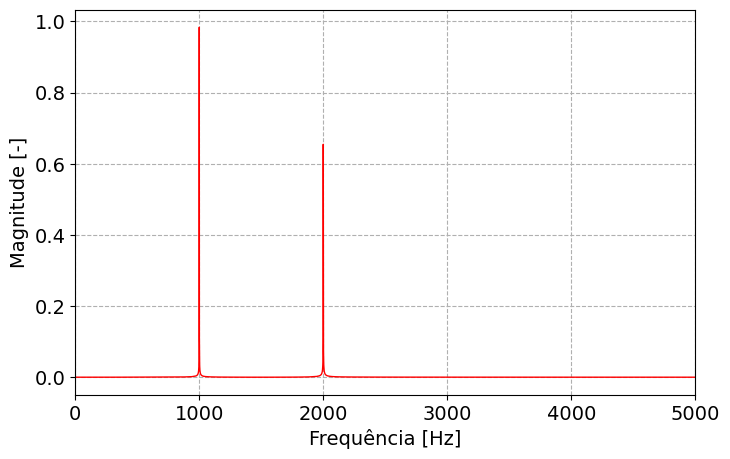

In [9]:
Xw = np.fft.fft(xt)
N = len(Xw)
f = np.linspace(0, (N-1)*Fs/N, N)

# Correção da magnitude
#Xw_mag = np.abs(Xw)       # Sem correção
#Xw_mag = np.abs(Xw)/N     # Com correção (sem efeito da simetria) 
Xw_mag = 2*np.abs(Xw)/N   # Com correção (com efeito da simetria) 

plt.figure(figsize=(8,5))
plt.plot(f, Xw_mag, '-r', linewidth = 1)
plt.grid(linestyle = '--', which='both')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [-]')
plt.xlim((0, Fs/2))
plt.show()

### Compare o valor médio do sinal com o valor de $X(k=0)$

In [10]:
print("O valor médio é {:.6f}".format(np.mean(xt)))
print("O da componente DC é {:.6f}".format(Xw[0]/N))

O valor médio é 0.000061
O da componente DC é 0.000061+0.000000j


## Sweep

Um sweep é um sinal dado por

\begin{equation}
x(t) = A \mathrm{cos}(2 \pi f(t) t)
\end{equation}
em que $f(t)$ evolui com o tempo. Podemos investigar uma evolução temporal linear ou logarítimica.

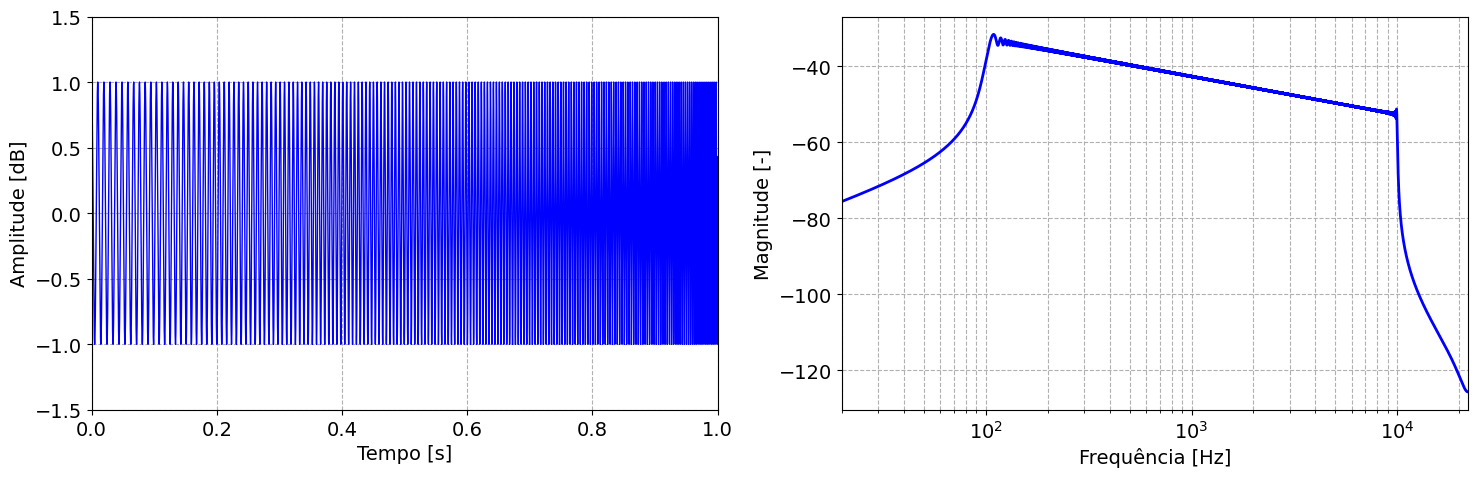

In [13]:
#### Sweep entre 100-10000  ######################
Fs = 44100
time = np.arange(0, 4, 1/Fs)
#xt = signal.chirp(time, 100, time[-1], 10000, method='linear') 
xt = signal.chirp(time, 100, time[-1], 10000, method='logarithmic')

# FFT
Xw = np.fft.fft(xt)
N = len(Xw)
freq = np.linspace(0, (N-1)*Fs/N, N)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(time, xt, '-b', linewidth = 1)
plt.grid(linestyle = '--', which='both')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude [dB]')
plt.xlim((0, 1))
plt.ylim((-1.5, 1.5))

plt.subplot(1,2,2)
plt.semilogx(freq, 20*np.log10(2*np.abs(Xw)/N), '-b', linewidth = 2)
plt.grid(linestyle = '--', which='both')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [-]')
plt.xlim((20, Fs/2))
plt.tight_layout()
plt.show()

ipd.Audio(xt, rate=Fs) # load a NumPy array

## Ruído branco

Tais sinais serão bastante avaliados em análise estatística de sinais. Eles são sequências pseudo-aleatórias geradas pelo computador, a partir de uma distribuição de probabilidade. Por exemplo, um ruído branco pode ser encarado como um sinal com distribuição dada por:

\begin{equation}
x(t) \ \text{~} \ \mathcal{N}(\mu_x = 0, \sigma_{x}^{2})
\end{equation}
em que $\mu_x$ é o valor médio do sinal e $\sigma_{x}^{2}$ é o quadrado do valor RMS.

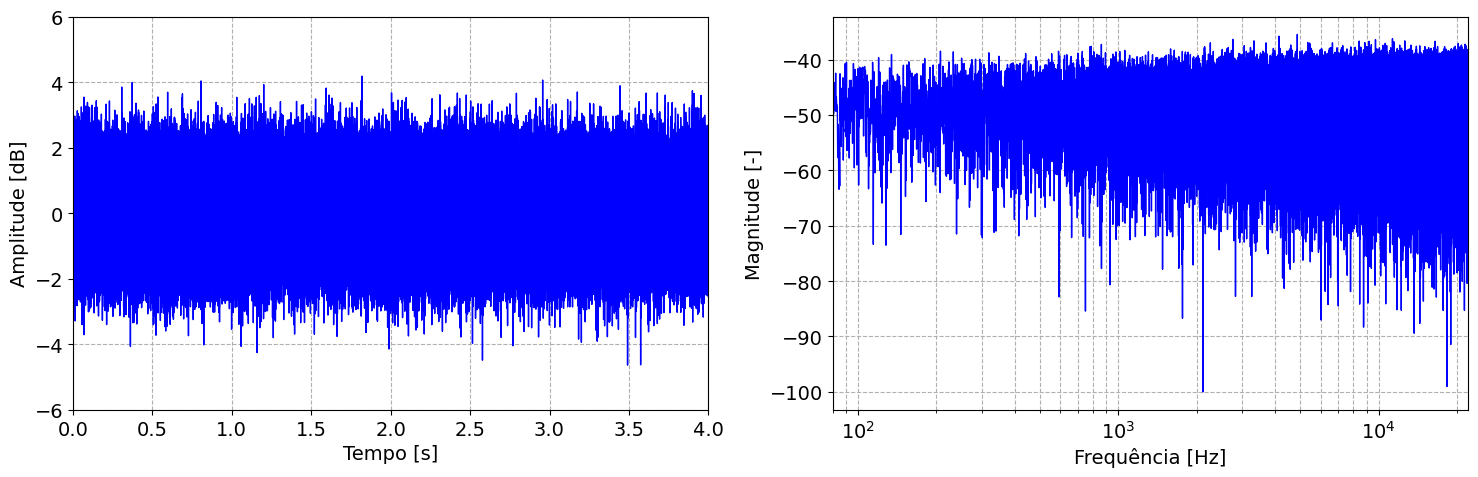

In [17]:
#### Ruído branco ######################
Fs = 44100
time = np.arange(0, 4, 1/Fs)
xt = np.random.normal(loc = 0, scale = 1, size = len(time))

# FFT
Xw = np.fft.fft(xt)
N = len(Xw)
freq = np.linspace(0, (N-1)*Fs/N, N)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(time, xt, '-b', linewidth = 1)
plt.grid(linestyle = '--', which='both')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude [dB]')
plt.xlim((0, 4))
plt.ylim((-6, 6))

plt.subplot(1,2,2)
plt.semilogx(freq, 20*np.log10(2*np.abs(Xw)/N), '-b', linewidth = 1)
plt.grid(linestyle = '--', which='both')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [-]')
plt.xlim((80, Fs/2))
plt.tight_layout()
plt.show()


ipd.Audio(xt, rate=Fs) # load a NumPy array